# Notebook XX: Evaluate Update

### Set up notebook

In [1]:
# import packages
import numpy as np
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib
import glob 
import os

from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# choose test case
case = 'DA30_vicen_MAT_mem_0025_noerr'
# case = 'DA30_vicen_MAT_mem_0005_noerr'

In [3]:
# define paths 
run_path = '/glade/scratch/mollyw/' + case + '/run/'
arc_path = '/glade/scratch/mollyw/archive/' + case + '/'

### Check DART files

First, check if the files are what we think that they are for a single assimilation case (so we know what we're going to be differencing to look at the update)

In [4]:
output = xr.open_dataset(run_path + 'cice.output_mean.2019-04-15-00000.nc')
# post = xr.open_dataset(run_path + 'cice.postassim_mean.2019-04-15-00000.nc')

# forecast = xr.open_dataset(run_path + '/assimilate_ice/forecast_mean.nc')
inp = xr.open_dataset(run_path + 'cice.input_mean.2019-04-15-00000.nc')
pre = xr.open_dataset(run_path + 'cice.preassim_mean.2019-04-15-00000.nc')

In [5]:
# check1 = output.equals(post)
# print(check1)

check2 = inp.equals(pre)
print(check2)

# check3 = pre.equals(forecast)
# print(check3)

True


Because we're running a single data assimilation cycle, the output/post-assimilation files are the same, as are the input/forecast/pre-assimilation files 
- TO DO: understand why these wouldn't be the same in a case with multiple cycles

Second, calculate an update.

### Calculate DART update

In [6]:
update = output.drop('cice_in') - pre.drop('cice_in')

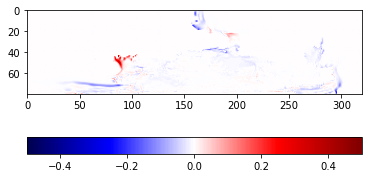

In [7]:
plt.imshow(update.aicen.sum(dim='ncat').sel(nj = slice(300,380)), vmin = -0.5, vmax =0.5, cmap=plt.cm.seismic)
plt.colorbar(orientation="horizontal", pad=0.2)

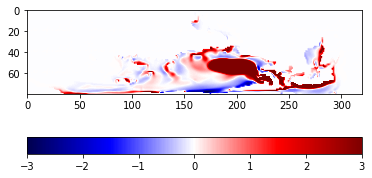

In [8]:
plt.imshow(update.vicen.sum(dim='ncat').sel(nj = slice(300,380)), vmin = -3, vmax = 3, cmap = plt.cm.seismic)
plt.colorbar(orientation="horizontal", pad=0.2)

Okay so now try to make a nice map out of this file.

In [9]:
nps = ccrs.NorthPolarStereo()
coords = nps.transform_points(
    ccrs.PlateCarree(), np.array(pre['ULON']), np.array(pre['ULAT']))


xs = np.ma.masked_invalid(coords[..., 0])
ys = np.ma.masked_invalid(coords[..., 1])
data = np.ma.masked_invalid(update.aicen.sum(dim='ncat'))
data2 = np.ma.masked_invalid(update.vicen.sum(dim='ncat'))

data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
data2.mask = np.logical_or(data2.mask, xs.mask, ys.mask)

# Matplotlib's contour can't handle masked arrays.
# But it doesn't matter, as the data is now masked at these locations.
xs = xs.filled(0)
ys = ys.filled(0)

AICEN map

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


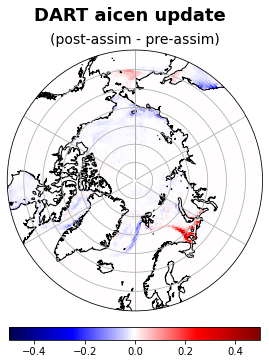

In [10]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 0.5
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, data, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')

plt.title('(post-assim - pre-assim)', fontsize = 14)
plt.suptitle('DART aicen update', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

VICEN map

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


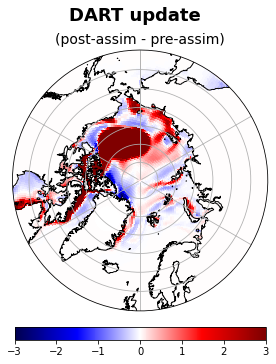

In [11]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 3
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, data2, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')

plt.title('(post-assim - pre-assim)', fontsize = 14)
plt.suptitle('DART update', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

So, in this case, where the ensemble 'truth' is member 0024, which has LESS volume of ice than the ensemble mean and close to the same area, the update **appears** to largely remove ice from the system in terms of volume, while maybe adding a lil bit of area. This is good. This makes sense. Wahoo. Let's check now if the spatial mean update tells us the same thing.

In [12]:
area_mean_change = update.aicen.sum(dim='ncat').mean(dim=['ni','nj'])
vol_mean_change = update.vicen.sum(dim='ncat').mean(dim=['ni','nj'])

print(area_mean_change.values.round(5), 'change in mean area')
print(vol_mean_change.values.round(5), 'change in mean volume')

-0.00024 change in mean area
0.04367 change in mean volume


In [13]:
area_change = update.aicen.sum(dim='ncat').sum(dim=['ni','nj'])
vol_change = update.vicen.sum(dim='ncat').sum(dim=['ni','nj'])

print(area_change.values.round(6), 'change in total area')
print(vol_change.values.round(5), 'change in total volume')

-29.205173 change in total area
5365.96261 change in total volume


Okay, so we are in fact, in the aggregate and the mean, losing ice volume and gaining ice area in this case during the assimilation. Wonderful. This has been tested for member 0005 (opposite scenario) as well and the results also worked out.

### Summary

The update files are showing what we would expect from the ensemble configuration for a single assimilation adjustment in April of 2019. This implies that earlier confusion was like the result of a plotting/kernel/computation error, and is therefore spurious. The next step would be to compare the updates we see here to results from the history files to really hammer down consistency.

The freeboard case for mem 0024 shows the same pattern of adjustment, but by nearly 4 times as much in volume. 
- TO DO: dig into why this might be. May need to do some math.

### Check forecast history files

In [14]:
og_day = xr.open_dataset(arc_path + 'ice/hist/'+case+'.cice.h.2019-04-14.nc')
vicen_og = og_day.vicen
aicen_og = og_day.aicen

aicen_hist = xr.open_dataset(glob.glob(arc_path + 'ice/proc/tseries/day_1/'+case+'.cice.h.aicen.20190414-*[0-9]*.nc')[0]).sel(time=slice('2019-04-14','2019-04-16'))
vicen_hist = xr.open_dataset(glob.glob(arc_path + 'ice/proc/tseries/day_1/'+case+'.cice.h.vicen.20190414-*[0-9]*.nc')[0]).sel(time=slice('2019-04-14','2019-04-16'))

Check that the first day of the timeseries file is the same as the og_day file

In [15]:
check4 = vicen_og.isel(time=0).equals(vicen_hist.vicen.isel(time=0))
check4

True

Okay, so the first day of the timeseries file is indeed the end of 14th of April, depsite 'time' beginning at 00:00:00 on the 15th of April. Now let's work just with the timeseries file.

### Calculate update

In [16]:
update_hist = vicen_hist.isel(time = 1) - vicen_hist.isel(time=0)
model_step = update_hist.vicen.sum(dim='nc') - update.vicen.sum(dim='ncat')

In [17]:
nps = ccrs.NorthPolarStereo()
coords = nps.transform_points(
    ccrs.PlateCarree(), np.array(update_hist['ULON']), np.array(update_hist['ULAT']))


xs = np.ma.masked_invalid(coords[..., 0])
ys = np.ma.masked_invalid(coords[..., 1])
data = np.ma.masked_invalid(update_hist.vicen.sum(dim='nc'))

data.mask = np.logical_or(data.mask, xs.mask, ys.mask)

# Matplotlib's contour can't handle masked arrays.
# But it doesn't matter, as the data is now masked at these locations.
xs = xs.filled(0)
ys = ys.filled(0)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


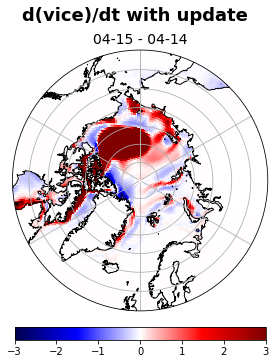

In [18]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 3
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, data, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

plt.title('04-15 - 04-14', fontsize = 14)
plt.suptitle('d(vice)/dt with update', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

### Look at difference between assimilated case and unassimilated case

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


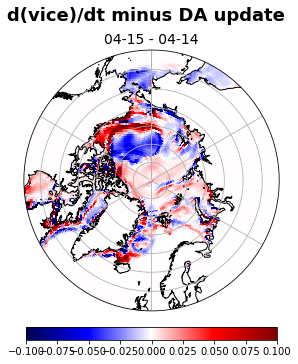

In [19]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 0.1
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, model_step, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

plt.title('04-15 - 04-14', fontsize = 14)
plt.suptitle('d(vice)/dt minus DA update', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

Check with the free ensemble that this is the same as a no-assimilation case.

In [20]:
vicen_free = xr.open_dataset('/glade/scratch/mollyw/archive/free30/ice/proc/tseries/day_1/free30.cice.h.vicen.20150101-20191230.nc').sel(time = slice('2019-04-15','2019-04-30'))

In [21]:
update_free = vicen_free.vicen.sum(dim='nc').isel(time=1) - vicen_free.vicen.sum(dim='nc').isel(time=0)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


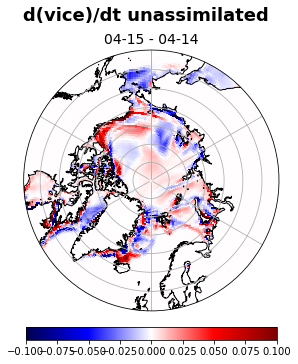

In [22]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 0.1
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, update_free, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

plt.title('04-15 - 04-14', fontsize = 14)
plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


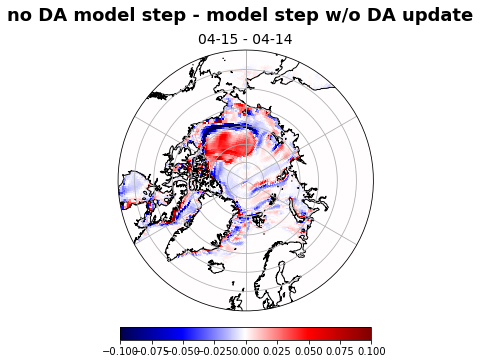

In [23]:
diff = update_free - model_step

fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 0.1
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, diff, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

plt.title('04-15 - 04-14', fontsize = 14)
plt.suptitle('no DA model step - model step w/o DA update', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

### Summary

When considering sea ice volume, the data assimilation update calculated from the DART files makes up the largest difference between the 1st and 2nd timesteps in the history files, which we might expect due to the pretty dramatic differences in total ice volume between the ensemble mean and the truth member (case 0024). When the update is removed from the assimilated case though, theoretically leaving only the model's evolution, there are O(0.1) differences between the remainder and the model evolution in the free, unassimilated case. Why is this?

*Idea*: the update made to the restart files acts as a perturbation to the model's ICs in a way that affects the forecast. Removing the update itself doesn't necessarily remove the impact that the update has had on the model (shifting the mean state around after-the-fact, but not changing the tweak to the model's trajectory introduced by the assimilation). **This is idea is somewhat supported by the fact that these differences are unique across cases that assimilate different truths.** This gives us a map of how the assimilation affects the forecast, aside from simply removing/adding ice (a kind of perturbation analysis)?

*Idea*: maybe this is the effect of post-processing? These small differences are the results of having to melt some ice for conservation due to adjustments that prescribe negative ice values? **This idea is maybe supported by the hypothesis that the freeboard adjustments are so funky because maybe they drive more negative adjustments, but seems less supported by the comparisons of model_step for the DART update and the "real" update calculated using the post-processed restart files, see end of this notebook.**

When this analysis is run for the **freeboard** case with mem 0024 truth, there are new discrepancies. Removing the update to ice volume (LOSS) calulated by DART leaves an ensemble that has an unexpected increase in ice volume from the first to the second timestep (this pattern is much further from the free, unassimilated case than the thickness assimilations), implying that the update has greatly altered the model's trajectory. Why is there this change?

*Idea*: perhaps assimilating freeboard causes many more grid cells of ice volume to become negative. In the postprocessing, they would be set to zero, and ice loss would be calculated and applied to each category proportionally. When this loss was removed, it should appear as though there was a lot more ice orginally? **This idea is NOT supported by a comparison of the model_step for both the DART update and real, post-processed update (there's very little different between them, so whatever is going wrong is likely before the post-processing step, see end of this notebook)**

Look for negative values in the DART output files

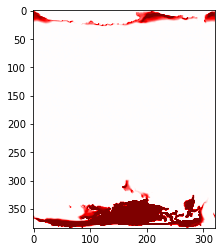

In [24]:
plt.imshow(output.vicen.sum(dim='ncat'), vmin = -1, vmax = 1, cmap = plt.cm.seismic)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


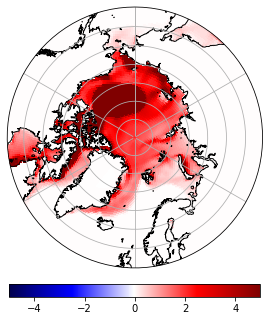

In [25]:
post_DART = output.vicen.sum(dim='ncat')
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 5
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, post_DART, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

# plt.title('04-15 - 04-14', fontsize = 14)
# plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

Okay so there are negative values as a result of the update, which means that this adjustment probably occurs prior to the postprocessing script dart_to_cice.f90. Confirm this. 

Confirmation: the DART process runs filter, which does the adjustment and writes out the {input, preassim, postassim, output} files. The post-processing script then runs though each ensemble member's restart file and rewrites it into the 'assimilate_ice/member_00XX' directory under dart_restart.nc. I need a mean of these files I think, to see the actual update including post-processing

In [26]:
restarts = xr.open_mfdataset(sorted(glob.glob('/glade/scratch/mollyw/'+case+'/run/assimilate_ice/member_00*[0-9]*/dart_restart.nc')), combine='nested', concat_dim = 'ens_member')

In [27]:
mean_restart = restarts.mean(dim = 'ens_member')

In [28]:
mean_restart_volume = mean_restart.vicen.sum(dim='ncat')

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


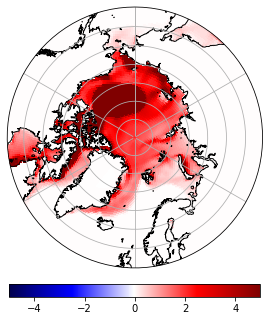

In [29]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 5
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, mean_restart_volume, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

# plt.title('04-15 - 04-14', fontsize = 14)
# plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

In [30]:
pre_DART = pre.vicen.sum(dim='ncat')
real_update = mean_restart_volume - pre_DART

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


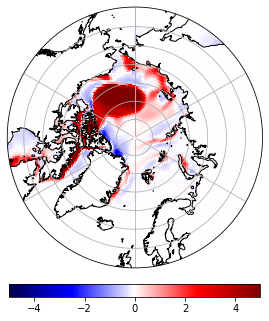

In [31]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 5
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, real_update, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

# plt.title('04-15 - 04-14', fontsize = 14)
# plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

This is the full update then (the mean of the restarts actually fed to CICE minus the preassimilation file). Does this make sense? Check against the update calculated as the postassmilation file minus the preassimilation file.

In [32]:
post_processing = real_update - data2

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


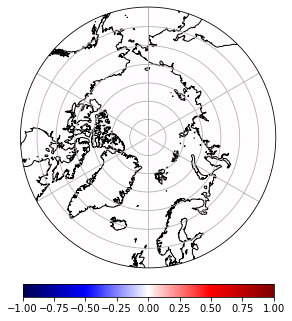

In [33]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 1
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, post_processing, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

# plt.title('04-15 - 04-14', fontsize = 14)
# plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()

Okay so in the freeboad cases, the postprocessing is adding some ice to the system (the real update has some more ice in it than the DART update). How does this fit into our understanding of the freeboard cases? 
- TO DO: answer this question

In [34]:
real_model_step = update_hist.vicen.sum(dim='nc') - real_update

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


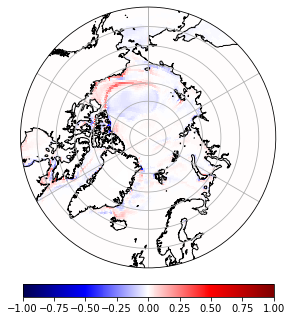

In [35]:
fig = plt.figure(figsize=(6, 6))

# set up projection 
ax = plt.axes(projection=nps)
ax.coastlines()
# ax.add_feature(cfeature.LAND,zorder=6)
ax.gridlines()

# set up boundaries
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

val = 1
mini = -1*val
maxi = val

cmap = plt.cm.seismic

plt.pcolormesh(xs, ys, real_model_step, vmin = mini, vmax = maxi, transform = nps, cmap = cmap)
labels = [round(x, 2) for x in np.linspace(mini, maxi, 10)]
cbar = plt.colorbar(shrink=0.75, pad = 0.05, orientation='horizontal')
# cbar.ax.set_xticklabels(labels,rotation=45)

# plt.title('04-15 - 04-14', fontsize = 14)
# plt.suptitle('d(vice)/dt unassimilated', fontsize = 18, fontweight='bold', color='black')

plt.tight_layout()